In [1]:
from autograd import grad
import autograd.numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

### The mnist data set
from fuel.datasets import MNIST
def get_data(datatype):
    mnist = MNIST((datatype,))
    state = mnist.open()
    im,_ = mnist.get_data(state=state, request=[i for i in range(int(mnist.num_examples/3))] )
    return im.reshape(im.shape[0],28*28)/255
data = get_data('train')
print(data.shape)

### Hyperparams
d = 784 #high d
m = 12 #low d - dim reduction

(20000, 784)


# Intro

In machine learning there is a very famous [result](https://users.ics.aalto.fi/oja/Oja92.pdf) that linear autoencoders learn the principle components from PCA. This is a quick investigation into some linear algebra, PCA itself, and its relation to autoencoders.

# PCA

What do we want to do? We want to find patterns in our data that can tell us about how the data is generated. So, one of the simplest ways to do this is to look at how each of the variables in our data change with each other. We can then use this to try to figure out how many variables our data actually has. For instance, if all of our variables increase with each other, then we could infer that they are all being generated by a single increasing variable.

### High level algorithm

* Find the covariance matrix.
* Find eigen vectors of covariance matrix.
* Pick principle components (aka eigenvectors) and apply.

### Covariance

We want to find out how each of our dimensions vary with each other one. 
* Does x change with y?
* Is x proportional to y?
* Is there a correlation between x and y?

So, according to wikipedia, the covariance of $X = X^T \cdot X $. This is the empirical approximation to the covariance, using data. Which is what we want.

So let's pick a simple example to play with, a (4,3) matrix of data samples/observations and features/dimensions.
$$
= \begin{bmatrix}
x_{1,1} & x_{2,1} & x_{3,1} \\
x_{1,2} & x_{2,2} & x_{3,2} \\
x_{1,3} & x_{2,3} & x_{3,3} \\
x_{1,4} & x_{2,4} & x_{3,4} \\
\end{bmatrix} 
\begin{bmatrix}
x_{1,1} & x_{1,2} & x_{1,3} & x_{1,4} \\
x_{2,1} & x_{2,2} & x_{2,3} & x_{2,4} \\
x_{3,1} & x_{3,2} & x_{3,3} & x_{3,4} \\
\end{bmatrix} \\
= \begin{bmatrix}
x_{1,1}x_{1,1} + x_{2,1}x_{2,1} + x_{3,1}x_{3,1} & x_{1,1}x_{1,2} + x_{2,1}x_{2,2} + x_{3,1}x_{3,2} & x_{1,1}x_{1,3} + x_{2,1}x_{2,3} + x_{3,1}x_{3,3} & x_{1,1}x_{1,4} + x_{2,1}x_{2,4} + x_{3,1}x_{3,4} \\
x_{1,2}x_{1,1} + x_{2,2}x_{2,1} + x_{3,2}x_{3,1} & x_{1,2}x_{1,2} + x_{2,2}x_{2,2} + x_{3,2}x_{3,2} & x_{1,2}x_{1,3} + x_{2,2}x_{2,3} + x_{3,2}x_{3,3} & x_{1,2}x_{1,4} + x_{2,2}x_{2,4} + x_{3,2}x_{3,4} \\
x_{1,3}x_{1,1} + x_{2,3}x_{2,1} + x_{3,3}x_{3,1} & x_{1,3}x_{1,2} + x_{2,3}x_{2,2} + x_{3,3}x_{3,2} & x_{1,3}x_{1,3} + x_{2,3}x_{2,3} + x_{3,3}x_{3,3} & x_{1,3}x_{1,4} + x_{2,3}x_{2,4} + x_{3,3}x_{3,4} \\
x_{1,4}x_{1,1} + x_{2,4}x_{2,1} + x_{3,4}x_{3,1} & x_{1,4}x_{1,2} + x_{2,4}x_{2,2} + x_{3,4}x_{3,2} & x_{1,4}x_{1,3} + x_{2,4}x_{2,3} + x_{3,4}x_{3,3} & x_{1,4}x_{1,4} + x_{2,4}x_{2,4} + x_{3,4}x_{3,4} \\
\end{bmatrix} \\
$$
Alternatively, we can view this matrix as the product of columns of X. Where $c_i$ indicates the ith column of X.
$$
= \begin{bmatrix}
c_1 \cdot c_1 & c_1 \cdot c_2 & c_1 \cdot c_3 & c_1 \cdot c_4 \\
c_2 \cdot c_1 & c_2 \cdot c_2 & c_2 \cdot c_3 & c_2 \cdot c_4 \\
c_3 \cdot c_1 & c_3 \cdot c_2 & c_3 \cdot c_3 & c_3 \cdot c_4 \\
c_4 \cdot c_1 & c_4 \cdot c_2 & c_4 \cdot c_3 & c_4 \cdot c_4 \\
\end{bmatrix}
$$

So what do entries of the covariance matrix really tell us? 
* Along the **diagonal** we have the sum of the squared values for a given column of X.
    * E.g. ```CoVar(X)[0,0]``` is $x_{1,1}x_{1,1} + x_{2,1}x_{2,1} + x_{3,1}x_{3,1} = c_1 \cdot c_1$
* The rest of the elements (**off-diagonal**) are the dot product of two different columns of X.
    * E.g. ```CoVar(X)[3,0]``` is $x_{1,4}x_{1,1} + x_{2,4}x_{2,1} + x_{3,4}x_{3,1} = c_4\cdot c_1$
    * Which is equivalent to the dot product of column 1 with column 4. 

Now comes the complicated part. $(-) \times (-) = (+), (+) \times (+) = (+), (-) \times (+) = (-)$ We can see that if two column entries, $x_{ij} x_{mn}$, have the same sign, so are in some binary-sense correlated, then they will result in a position value. If not, negative. From this, it is easily seen that when the elements of two columns are more similar, the higher the correlation. So for the diagonal entries we would expect to have values on 1.

The key to this is whitening (mean normalisation). The columns are whitened, so increasing the absolute value of a column will not necessarily result in higher correlation.

In [2]:
def whiten(x):
    #should i be normalising the variances?
    return (x-np.mean(x,0).reshape((1,x.shape[1]))) / np.sqrt(np.var(x,0).reshape((1,x.shape[1])) + 1e-10)
ims = whiten(data)
print(np.mean(ims))
print(np.var(ims)) #I would have expected this to be closer to 1?? why not?

1.3877017449e-15
0.887592711621


In [3]:
my_covar = np.dot(ims.T , ims)*(1/(ims.shape[0]))
their_covar = np.cov(ims.T)
print('My covariance = ',np.mean(my_covar))
print('Numpys approximation of the covariance = ',np.mean(their_covar))

My covariance =  0.0191289710081
Numpys approximation of the covariance =  0.0191299275045


### Eigen vecs/vals

Now that we have the covariances between variables/features of X, we can find their eigen values/vectors. Eigenvectors of a matrix, M, are directions that are not rotated when multiplied by M -- $\mathbf{A}\vec{x} = a\vec{x}$. So, the eigenvectors of our covariance matrix are directions that ???

Why does it even make sense that there are m eigen vectors? It seems weird that there must be directions that are invariant to rotation.

In [40]:
eigenvals,eigenvecs = np.linalg.eig(my_covar)
#check they are unit vectors. #why is this important?
print('Norm of eigen vector = {:.2f}'.format(np.linalg.norm(eigenvecs[:,0])))
print(eigenvals[0:m])

Norm of eigen vector = 1.00
[ 40.49157799  29.91704775  27.16369023  20.71694131  18.03095171
  15.82937512  14.0352874   12.61189969  11.2694569   10.22088582
   9.74467121   8.54061405]


In [44]:
#Ax =ax => Axx-1 = a
x = eigenvecs[:,0]
print(np.dot(np.dot(my_covar,x).reshape((1,784)),x))

[ 40.49157799]


$Ax = ax \implies (A-aI)x = 0$

Hmm. Eigen vectors are not unique??


Now take whichever eigenvectors you like, but really we want the ones with the greatest eigenvalues. This is because the eigen values are the variances of our eigen vectors. As ... ???

hmm. should these all be positive? - the eigen values

then multiply data . selected eigenvectors. But wait a minute, arent the eigen vectos for the co-variance matrix, not the data? So really, the eigen vectors are ???

In [8]:
principle_component_directions = eigenvecs[:,0:m] #take the first 5 dimensions
transform = np.dot(ims,principle_component_directions)
#why does this work? we are multiplying the ???
transform.shape

(20000, 12)

In [9]:
def plotter(x):
    plt.figure(figsize=(16,16))
    for i in range(m):
        plt.subplot(math.ceil(m/3),3,i+1)
        plt.imshow(x[:,i].reshape(28,28),cmap='Greys_r')
        plt.title('Component {}'.format(i))

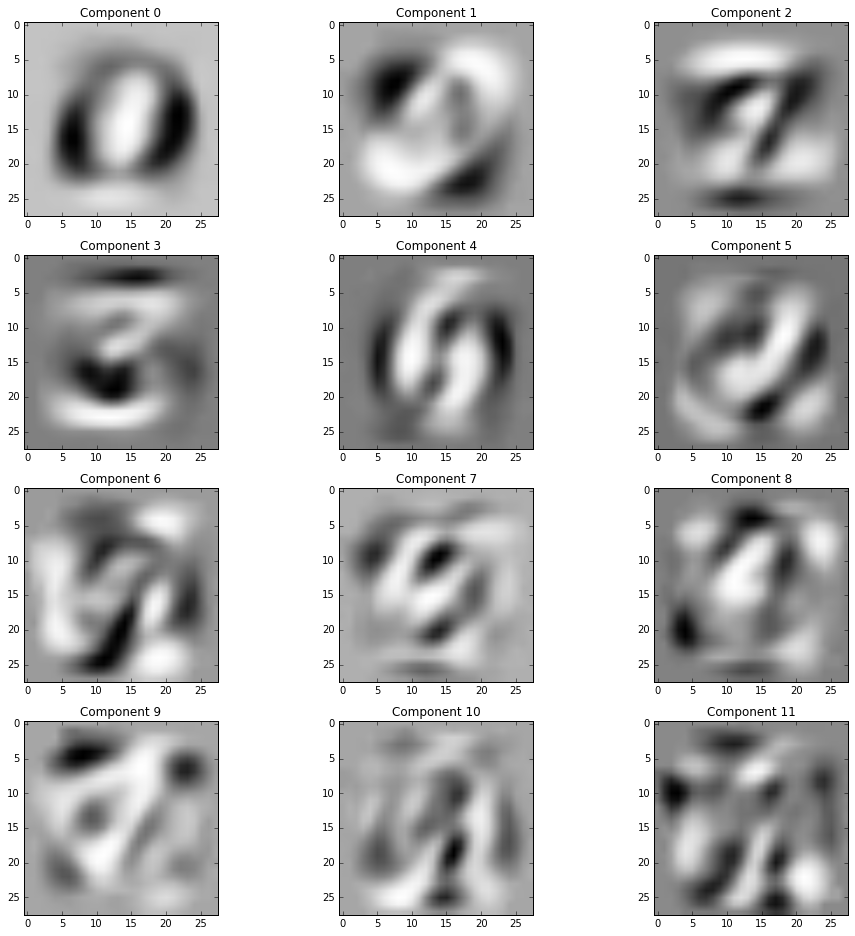

In [10]:
plotter(principle_component_directions)

In [11]:
# Reconstruction error of PCA
# reconstruct the images by transofrming the data into the selected compoents and then back.
def Squared_Error(x,y):
    return np.mean(np.sum((x - y)**2,1))  

PCA_reconstruction = np.dot(np.dot(ims,principle_component_directions),principle_component_directions.T)
print('The reconstruction error of PCA with {} features is {}'.format(m,Squared_Error(PCA_reconstruction,ims)))

The reconstruction error of PCA with 12 features is 477.3002867228067


In [24]:
feat_err_percent.shape

(29,)

/Users/act65/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The reconstruction error of PCA with 0.0 features is 695.87 which is 0.000%
The reconstruction error of PCA with 28.0 features is 380.16 which is 0.454%
The reconstruction error of PCA with 56.0 features is 280.32 which is 0.597%
The reconstruction error of PCA with 84.0 features is 217.03 which is 0.688%
The reconstruction error of PCA with 112.0 features is 169.43 which is 0.757%
The reconstruction error of PCA with 140.0 features is 133.49 which is 0.808%
The reconstruction error of PCA with 168.0 features is 105.85 which is 0.848%
The reconstruction error of PCA with 196.0 features is 84.37 which is 0.879%
The reconstruction error of PCA with 224.0 features is 67.32 which is 0.903%
The reconstruction error of PCA with 252.0 features is 54.59 which is 0.922%
The reconstruction error of PCA with 280.0 features is 44.86 which is 0.936%
The reconstruction error of PCA with 308.0 features is 37.03 which is 0.947%
The reconstruction error of PCA with 336.0 features is 31.02 which is 0.95

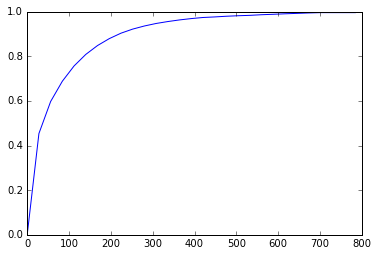

In [29]:
# how does the reconstruction error depend on the amount of 
I = 28+1
k = np.zeros(I)
feat_err = np.zeros(I)
feat_err_percent = np.zeros(I)
for i in range(I):
    k[i] = 28*(i)
    PCA_recon = np.dot(np.dot(ims,eigenvecs[:,0:k[i]]),eigenvecs[:,0:k[i]].T)
    feat_err[i] = Squared_Error(PCA_recon,ims)
    feat_err_percent[i] = (695.9-feat_err[i])/695.9
    print('The reconstruction error of PCA with {} features is {:.2f} which is {:.3f}%'
          .format(k[i],feat_err[i],feat_err_percent[i]))
plt.plot(k,feat_err_percent)

Hmm. Ok, i wasnt expecting that. So is that left over error due to numercal rounding errors or because something as gone wrong?

Otherwise, I was expecting that. We get diminishing returns on adding more features. This makes sense as we know from our eariler analysis that the directions the eigenvectors give us account for less variance. Therefore, ... ???

* Are the eigen values equal to the change in squared error? Seems pretty close??
* So, this related to overfitting? How do we know when we are using too many dimensions/features? 
* So the direction/eigenvector that gives the most variance looks remarkably like a zero. (why??)
* In what sense are each of these images orthogonal to each other?

### Questions
* Also, we would expect that an autoencoder with n nodes in its bottle neck can do no better than these values (????)
* How do we actally find the eigen vectors? Optimisation?

### Singular value decomposition
Used as an alternative way to find eigen vectors? Why?

Is ?

> * The columns of V (right-singular vectors) are eigenvectors of M∗M.
* The columns of U (left-singular vectors) are eigenvectors of MM∗.
* The non-zero elements of Σ (non-zero singular values) are the square roots of the non-zero eigenvalues of M∗M or MM∗.

Show/prove? this

Let Ax = ax, aka x is an eigen vector of A. Then let A = USV, then Ux = ? = xV = x? As eigen vectors are only scaled, not rotated.

In [13]:
### Using numpy - covariance and SVD
U, S, V = np.linalg.svd(their_covar, full_matrices=True)
print('Principle component variance = ',np.max(S))

Principle component variance =  40.4936026729


In [14]:
### Using sklearn's PCA
pca = PCA(n_components=5,whiten=True)
pca.fit(data)
print('Principle component variance = ',pca.explained_variance_)

Principle component variance =  [ 5.22342628  3.75713234  3.35175     2.86890072  2.52735308]


## Linear autoencoders

So now we are ready to test out how if a linear autoencoder learns PCA.

Should I be normalising the columns of the weights? Why was this important in PCA?

In [34]:
def LinearAE(w,x): #a two layer encoder-decoder
    return np.dot(np.dot(x,w),w.T)

def Loss(w,x): #squared error
    return Squared_Error(x , LinearAE(w,x))
dL = grad(Loss) #the magic of autograd

def train(w):
    #A simple two layer linear autoencoder
    N = 10000
    for i in range(N):
        #stochastic gradient descent
        batch = ims[np.random.choice([n for n in range(ims.shape[0])],50),:]  #train on mini-batches
        w -= 0.0005* dL(w,batch) #update rule - follow the gradient downhill

        if i%(N/20) ==0:
            batch = ims[np.random.choice([n for n in range(ims.shape[0])],500),:]
            print(Loss(w,batch))
    return w

718.185350036
334.899512481
428.125458237
307.791142062
381.271551282
464.095663814
357.910648845
441.015106416
362.59844976
438.30440198
467.616536989
321.633362689
273.677961717
370.261858451
405.922340193
375.773859677
348.028561438
355.399785047
326.538924934
356.98570036
The reconstruction error of a linear AE with 12 features is 380.82555425137576


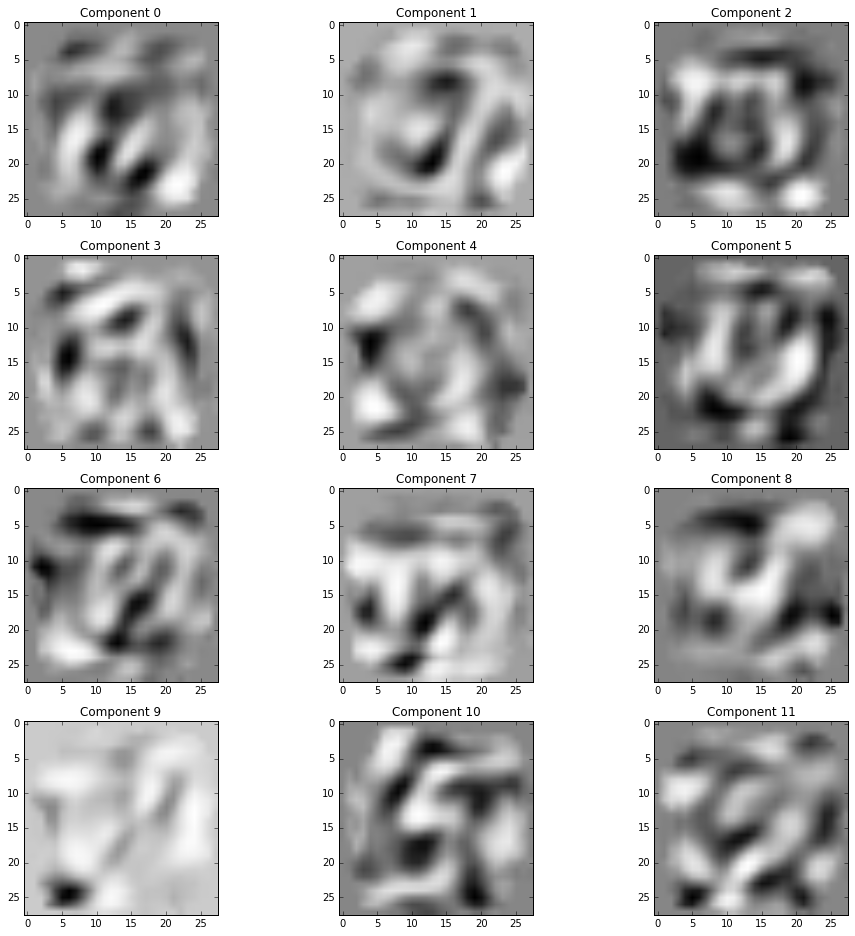

In [35]:
#init the weights - the typical init of NNs
Weights = 0.001*np.random.standard_normal((784,28))
Weights = train(Weights)
plotter(Weights)
print('The reconstruction error of a linear AE with {} features is {}'.format(m,Squared_Error(LinearAE(Weights,ims), ims)))

669.696342719
669.836723425
676.89928646
665.198939122
615.473735391
649.831597938
740.530001568
614.46593456
717.58488793
719.53537354
621.33645775
721.596531159
618.981278638
589.496722941
613.164808274
659.819767421
619.241978638
659.658728085
611.774884798
738.03976623
The reconstruction error of a linear AE with 12 features is 380.82555425137576


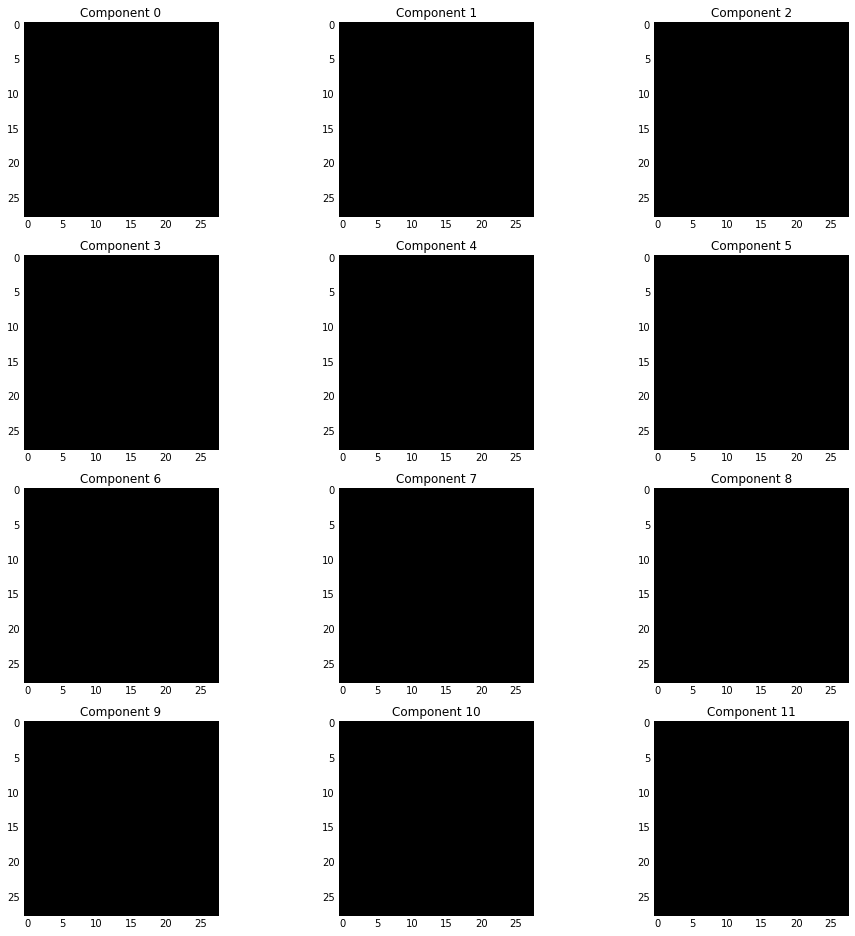

In [45]:
#Does it learn different components if we initialise all the weights to be the same?
Zero_Weights = np.zeros((784,m))
Zero_Weights = train(Zero_Weights)
plotter(Zero_Weights)
print('The reconstruction error of a linear AE with {} features is {}'.format(m,Squared_Error(LinearAE(Weights,ims), ims)))

So has this one really learnt orthogonal components???

Well, no point in learning the same thing twice. (but dropout would not let this happen, I would how many times we end up learning the same thing...)

436.135846199
647.901432511
464.071805008
449.487947704
473.678603183
The reconstruction error of a linear AE with 12 features is 479.0835772664966


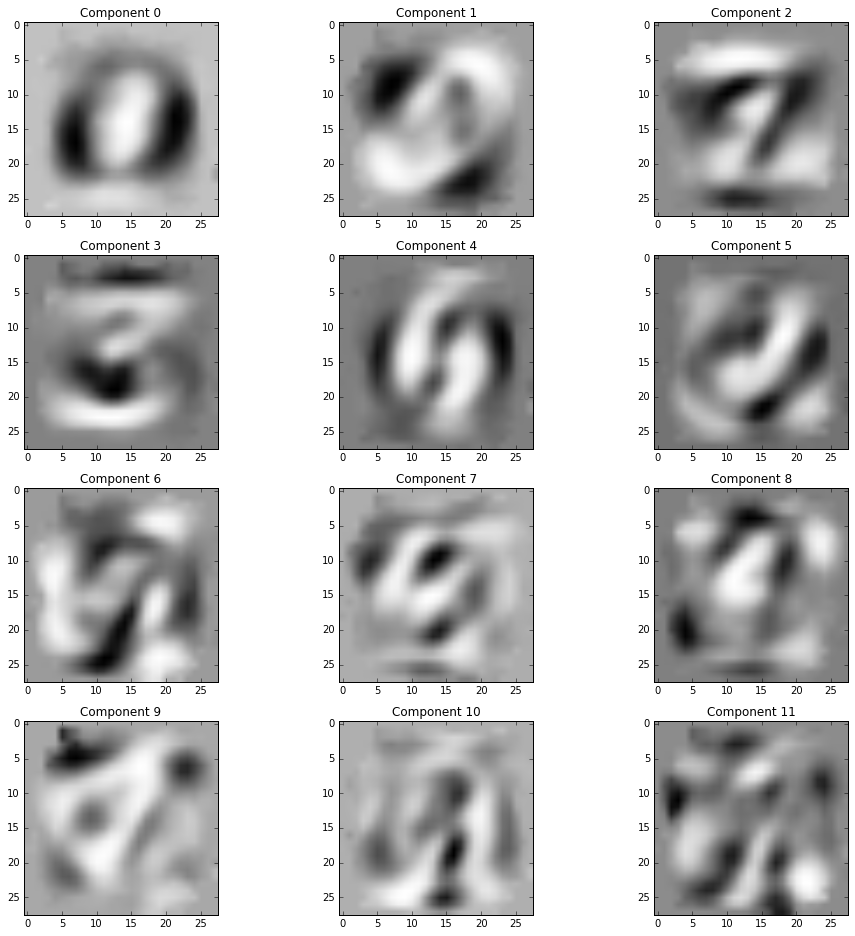

In [17]:
#Now lets try our linear autoencoder with its weights initialised from PCA
Better_init_Weights = principle_component_directions
Better_init_Weights = train(Better_init_Weights)
plotter(Better_init_Weights)
print('The reconstruction error of a linear AE with {} features is {}'.format(m,Squared_Error(LinearAE(Better_init_Weights,ims), ims)))

In [37]:
#Find the variance explained by the learned weights aka feature vectors
#Ax = ax => (Ax)x-1 = a 
def find_variance_explained(x):
    eigen_variances = []
    for i in range(m):
        #this is not the right way to do it... pretty sure i am cheating with the mean/median?
        #mean doesnt work because of all the zeros.
        eigen_variances.append( np.median(np.dot(my_covar, x[:,i]) / (x[:,i]+1e-15)))
    print(eigen_variances)
find_variance_explained(Better_init_Weights)
find_variance_explained(principle_component_directions)
find_variance_explained(Weights)

[39.129129699806924, 29.395022522123121, 26.74051304163789, 20.211337304434817, 17.586287994892423, 15.537790385521941, 13.884452758575327, 12.484800577330297, 10.988694816080603, 10.028971424708732, 9.4380646128475583, 8.3281119857767933]
[39.129129699806924, 29.395022522123121, 26.74051304163789, 20.211337304434817, 17.586287994892423, 15.537790385521941, 13.884452758575327, 12.484800577330297, 10.988694816080603, 10.028971424708732, 9.4380646128475583, 8.3281119857767933]
[7.2349852232248093, 6.7957863068977327, 12.923966337107252, 10.510062907667772, 9.8224055100422412, 7.3397092725253739, 8.4955128483682714, 9.1064531261709796, 12.438099847049983, 6.8339399768125482, 7.955691765816101, 8.8924632505922538]


So, an AE is trying to maximise the variance each middle node sees across the dataset. But they also interefere with eachother, competitively? Why do they learn this??? More variance captures more 'information'? Easier to separate?

### Why?

* Does linear imply convexity?? Yes and no.(?)
* So then the minimal loss comes from using the principle components.
* How does the update rule imply we will learn the principle components?
* If we initialised every weight to be the same, would it end up learning the same components?
* Why does it learn perpendicular directions? Caputres more information, but how does it know that???
* Without biases??
* Multi layer nets? Doing PCA of PCA... if linear this doesnt make sense. But why does it make sense for non-linear layers?
* Why does MSE equal $(x-y)^2$ rather than $(y-x)^2$??
* Not having tied weights, aka having more parameters may help training as the problem will be convex wrt to each weight.


##### Let's go through a 2d case (weights tied).

$$
\left[ \begin{array}{c}   y_1\\ y_2 \\ \end{array} \right]
= \begin{bmatrix} 
W_1 \\ 
W_2 \\
\end{bmatrix}
\begin{bmatrix} 
W_1 & W_2 \\ 
\end{bmatrix} \left[ \begin{array}{c}  x_1\\ x_2\\ \end{array} \right] \\
= \left[ \begin{array}{c}  W_1(W_1x_1 + W_2x_2)   \\ W_2(W_1x_1 + W_2x_2) \\ \end{array} \right] 
$$

$$
\begin{align}
\mathcal{L} &= (\textbf{x}-\textbf{y})^2\\
&= \left[ \begin{array}{c}  
(x_1 - W_1(W_1x_1 + W_2x_2) )^2  \\ 
(x_2 - W_2(W_1x_1 + W_2x_2) )^2 \\ 
\end{array} \right] \\
&= \left[ \begin{array}{c}  
(x_1 - W_1^2x_1 - W_1W_2x_2)^2  \\ 
(x_2 - W_2W_1x_1 - W_2^2x_2)^2 \\ \end{array} \right] \\
&= \left[ \begin{array}{c}  
  \\ 
 \\ \end{array} \right] 
\end{align}
$$

### Questions

* What if we dont tie the weights? Does it end up learning symetric ones anyway?
* So in what sense is PCA minimising the squared error? 

### Resources
* https://en.wikipedia.org/wiki/Covariance_matrix
* http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf
* http://mengnote.blogspot.co.nz/2013/05/an-intuitive-explanation-of-pca.html
* [Principle components, minor components and linear networks - Oja](https://users.ics.aalto.fi/oja/Oja92.pdf)
* [Neural Networks and Principal Component Analysis: Learning from Examples Without Local Minima](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.408.1839&rep=rep1&type=pdf)
* [Mixtures of Probabilistic Principal Component Analysers](http://www.miketipping.com/papers/met-mppca.pdf)